<img src="./pictures/DroneApp_logo.png" style="float:right; max-width: 180px; display: inline" alt="INSA" />
<img src="./pictures/logo_sizinglab.png" style="float:right; max-width: 100px; display: inline" alt="INSA" />

## Dynamic models for propellers
*Written by Marc Budinger, Aitor Ochotorena(INSA Toulouse) and Scott Delbecq (ISAE-SUPAERO), Toulouse, France.*


The complexity of the propellers characteristics increases as they work in dynamic scenarios. So far, we have seen how $C_T$ and $C_P$ coefficients can be well expressed in terms of geometric ratio (pitch/diameter). In these dynamic scenarios, these coefficients depend also on the speed.  Based on dimensional analysis and the polynomial regression of suppliers data, adequate prediction models for $C_T$ and $C_P$ are generated. 


*Flow distribution in multirotor vehicle for climbing*
![Climbing](./pictures/drone_axial_vertical_flight.png)


1. [Propeller regression](#section_1)
2. [Pareto filtering](#section_2)

<a id='section_1'></a>

### Propeller regression

### Data analysis

Based on the datasheets of different models of *APC propellers MR*, estimation models are developed to characterize the thrust and power coefficients of the propellers for dynamic scenarios. In the next DataFrame, an extra column is added to calculate the value of the dimensionless air compressibility estimation or B coefficient.

In [1]:
import pandas as pd
import math

# Read the .csv file with bearing data
path='./docs/'
df = pd.read_csv(path+'Propeller_Data.csv', sep=';')
K=101000 #[Pa] bulk modulus air
df['B coef']=1.18*(df['RPM']/60*2*3.14)**(2)*(df['DIAMETER_in']*0.0254)**(2)/K

# Print the head (first lines of the file)
df.head()

,TYPE,Model,BETA,J,V_mph,Pe,Ct,Cp,PWR_Hp,Torque_In-Lbf,Thrust_Lbf,DIAMETER_in,Ct*,Cp*,RPM,B coef
0,APC MR,APC MR,0.45,0.00,0.0,0.0000,0.1102,0.0428,0.003,0.087,0.140,10,0.110371,0.040802,2000,0.03303
1,APC MR,APC MR,0.45,0.02,0.5,0.0621,0.1086,0.0432,0.003,0.088,0.138,10,0.109003,0.041500,2000,0.03303
2,APC MR,APC MR,0.45,0.05,0.9,0.1212,0.1068,0.0435,0.003,0.088,0.136,10,0.106725,0.042363,2000,0.03303
3,APC MR,APC MR,0.45,0.07,1.4,0.1774,0.1050,0.0439,0.003,0.089,0.134,10,0.105059,0.042815,2000,0.03303
4,APC MR,APC MR,0.45,0.10,1.9,0.2305,0.1030,0.0442,0.003,0.090,0.131,10,0.102340,0.043307,2000,0.03303


### Heatmap

The use of Heatmaps enables to visualize numerically the dependence of the parameters on each others to describe their behaviour. A value close to '1' will mean a very strong dependence, while a value close to '0' means a negligible effect. We see how $Cp$ and $Ct$ do not longer depend only on beta to describe their behaviour. A tutorial of seaborn heatmap can be found [here](https://likegeeks.com/seaborn-heatmap-tutorial/).

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


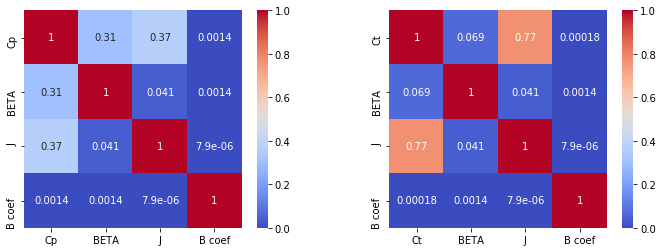

In [3]:

f, axes = plt.subplots(1,2,figsize=(12,4))

df_Cp=df[['Cp','BETA','J', 'B coef']]
df_Ct=df[['Ct','BETA','J', 'B coef']]

# heatmap
sns.heatmap(df_Cp.corr(method='pearson')**2,annot=True,cmap='coolwarm',square=True, ax=axes[0])
sns.heatmap(df_Ct.corr(method='pearson')**2,annot=True,cmap='coolwarm',square=True, ax=axes[1])



### Scatter matrix

Another technique very similar to the heatmap to observe dependencies is the scatter matrix, in which we can represent in a matrix small subplots. Here we are interested in studying the trend of the parameter rather than knowing the exact value of the magnitude.

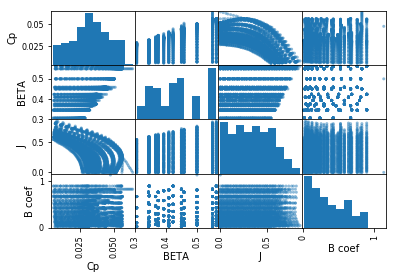

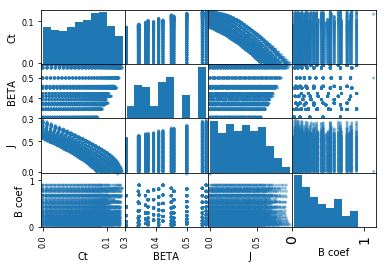

In [4]:
pd.plotting.scatter_matrix(df_Cp)
pd.plotting.scatter_matrix(df_Ct)
plt.tick_params(axis = 'both', labelsize = 14)
plt.rcParams.update({'font.size': 14})


### Surrogate modeling techniques

In this part, data are fitted using a non-linear polynomial model regression. For this purpose, a polynomial $(beta+ J)^n$ is developed using the package `PolynomialFeatures` of [scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to a degree n, whose value of determination coefficient ($R^2$) is higher than required.
As a condition, we set that the value of R squared required must be $R_{est}=0.98$
At the end, data and the surrogate model are plotted in a 3D graph.

Steps:
1. Read the dependent variable (in our case $C_T$ or $C_P$) and non-dependent variables ($\beta$ and J) from the dataframe.
2. We set up a minimum coefficient of determination $R^2$, for which the mathematical model must fit the data.
3. A binomial expansion in the form of $(\beta +J )^n$ is developed to fit the data values. The polynomial will raise until the R-squared value reaches the desired limit.
4. We plot together the values and the equation found in a 3D-graph and we print the expression.

- $C_p=f(\beta,J)$

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
%matplotlib widget 


RMSE= 0.0017373644408107075
R2= 0.9835214253248169
Cp= +(0.046)*1+(0.036)*J+(-0.301)*BETA+(-0.017)*J^2+(-0.241)*J BETA+(1.054)*BETA^2+(-0.062)*J^3+(-0.088)*J^2 BETA+(0.441)*J BETA^2+(-0.890)*BETA^3


<IPython.core.display.Javascript object>


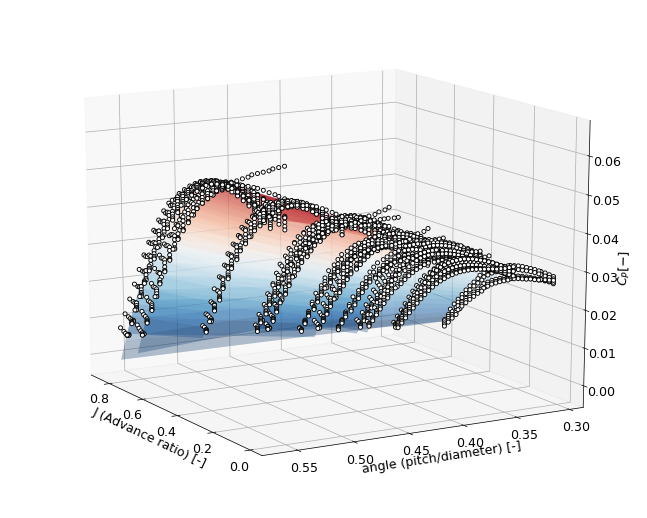

In [10]:

R_est=0.98 # minimum R-squared value to achieve

# read dataframe values
X = df[['J', 'BETA']].values
y1 = df['Cp'].values

# extracting columns from X
mu_col=X[:,0] 
beta_col=X[:,1]

#a matrix of mu and beta is made
XX = np.concatenate((mu_col.reshape(np.size(y1),1),beta_col.reshape(np.size(y1),1)),axis=1)

# in this while we increase the polynomial binomium until R2 reaches the limit
i=1 # start by 1.Grade polynomium 
while True:
    poly = PolynomialFeatures(i) # development of i-grade polynomium
    x_poly = poly.fit_transform(XX)

    model = sm.OLS(y1, x_poly) #fit regression model to the data
    result= model.fit() # save value of coeficients
    y_poly_pred = result.predict(x_poly) # according to the regression model found, a value of y is generated

    rmse = np.sqrt(mean_squared_error(y1,y_poly_pred)) #Root mean square error
    r2 = r2_score(y1,y_poly_pred) #R2 correlation value
    i +=1 # we increase the polynomium degre
    if r2>R_est: #if R2 calculated is greater than 
        break
print("RMSE=",rmse)
print("R2=",r2)

#here we expand the formula of the i-degree polynomium
data = pd.DataFrame.from_dict({
    'J': np.random.randint(low=1, high=10, size=5),
    'BETA': np.random.randint(low=-1, high=1, size=5),
})

p = PolynomialFeatures(degree=i-1).fit(data)

#concatenate the OLS regression parameters with variables 
string1=['+({:.3f})*'.format(x) for x in result.params]
string2=p.get_feature_names(data.columns)

Result=""
for i in range(len(string1)):
        Result += string1[i]
        Result += string2[i]
print('Cp=',Result)


#meshgrid 3D for plot
xx1, xx2 = np.meshgrid(np.linspace(mu_col.min(), mu_col.max(), len(y1)), 
                       np.linspace(beta_col.min(), beta_col.max(), len(y1)))


#create the 3D axis 
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig, azim=-210, elev=15)


ax.scatter(mu_col, beta_col, y1, color='black', alpha=1.0, facecolor='white')

# reshape data to suit in the grid. Here a x b = len(y1)
xp = np.reshape(mu_col, (94, 30))
yp = np.reshape(beta_col, (94, 30))
zp = np.reshape(y_poly_pred, (94, 30))

# plotting the predicted surface
ax.plot_surface(xp, yp, zp, cmap=plt.cm.RdBu_r, alpha=0.3, linewidth=0)

#axis labels
ax.set_xlabel('J (Advance ratio) [-]',fontsize=14)
ax.set_ylabel('angle (pitch/diameter) [-]',fontsize=14)
ax.set_zlabel(r'$C_P [-]$',fontsize=14)

plt.grid()

plt.tick_params(axis = 'both', labelsize = 14)

- $C_t=f(\beta,J)$

RMSE= 0.001993438826418841
R2= 0.996586233013187
Ct= +(0.011)*1+(-0.141)*mu+(0.282)*beta+(-0.133)*mu^2+(0.164)*mu beta+(-0.139)*beta^2


<IPython.core.display.Javascript object>


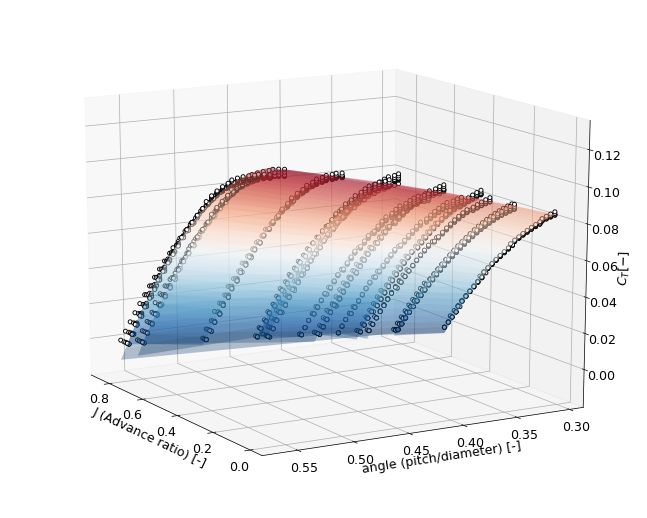

In [11]:
R_est=0.98 # minimum R-squared value to achieve

# read dataframe values
X = df[['J', 'BETA']].values
y1 = df['Ct'].values

# extracting columns from X
mu_col=X[:,0] 
beta_col=X[:,1]

#a matrix of mu and beta is made
XX = np.concatenate((mu_col.reshape(np.size(y1),1),beta_col.reshape(np.size(y1),1)),axis=1)

# in this while we increase the polynomial binomium until R2 reaches the limit
i=1 # start by 1.Grade polynomium 
while True:
    poly = PolynomialFeatures(i) # development of i-grade polynomium
    x_poly = poly.fit_transform(XX)

    model = sm.OLS(y1, x_poly) #fit regression model to the data
    result= model.fit() # save value of coeficients
    y_poly_pred = result.predict(x_poly) # according to the regression model found, a value of y is generated

    rmse = np.sqrt(mean_squared_error(y1,y_poly_pred)) #Root mean square error
    r2 = r2_score(y1,y_poly_pred) #R2 correlation value
    i +=1 # we increase the polynomium degre
    if r2>R_est: #if R2 calculated is greater than 
        break
print("RMSE=",rmse)
print("R2=",r2)

#here we expand the formula of the i-degree polynomium
data = pd.DataFrame.from_dict({
    'mu': np.random.randint(low=1, high=10, size=5),
    'beta': np.random.randint(low=-1, high=1, size=5),
})

p = PolynomialFeatures(degree=i-1).fit(data)

#concatenate the OLS regression parameters with variables 
string1=['+({:.3f})*'.format(x) for x in result.params]
string2=p.get_feature_names(data.columns)

Result=""
for i in range(len(string1)):
        Result += string1[i]
        Result += string2[i]
print('Ct=',Result)


#meshgrid 3D for plot
xx1, xx2 = np.meshgrid(np.linspace(mu_col.min(), mu_col.max(), len(y1)), 
                       np.linspace(beta_col.min(), beta_col.max(), len(y1)))


#create the 3D axis 
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig, azim=-210, elev=15)


ax.scatter(mu_col, beta_col, y1, color='black', alpha=1.0, facecolor='white')

# reshape data to suit in the grid. Here a x b = len(y1)
xp = np.reshape(mu_col, (94, 30))
yp = np.reshape(beta_col, (94, 30))
zp = np.reshape(y_poly_pred, (94, 30))

# plotting the predicted surface
ax.plot_surface(xp, yp, zp, cmap=plt.cm.RdBu_r, alpha=0.3, linewidth=0)

#axis labels
ax.set_xlabel('J (Advance ratio) [-]',fontsize=14)
ax.set_ylabel('angle (pitch/diameter) [-]',fontsize=14)
ax.set_zlabel(r'$C_T [-]$',fontsize=14)

plt.grid()

plt.tick_params(axis = 'both', labelsize = 14)


<a id='section_4'></a>

<a id='section_2'></a>

### Pareto filtering: High thrust and small diameter

In [1]:
# This function tests if a component is dominated
# return 0 if non dominated, the number of domination other else
# inputs :
# x_,y_ : the  component's characteristics to test
# X_,Y_ : the  data set characteristics

def dominated(x_,y_,X_,Y_):
    compteur=0
    for a,b in zip(X_,Y_):
        # a>x_ for high torque and  b<y_ for small weight
        if (a>x_) and (b<y_):
            compteur +=1
    return compteur

<IPython.core.display.Javascript object>


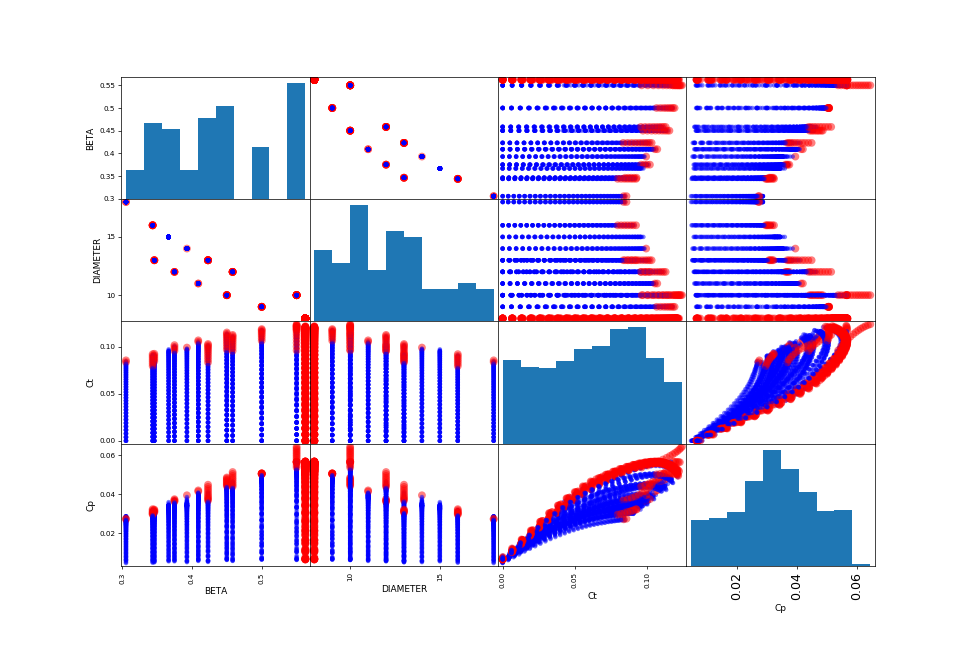

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

path='./data/'
df_pro = pd.read_csv(path+'Propeller_Data.csv', sep=';')


df_pro['Dominated']=0

df_pro = df_pro.reset_index(drop=True)# clear row index after ignoring one family battery

for row in range(len(df_pro['Ct'])):
    if dominated(df_pro.loc[row,'Thrust'], df_pro.loc[row,'DIAMETER'],df_pro['Thrust'].values,df_pro['DIAMETER'].values)>0:
        df_pro.loc[row,'Dominated']=1    

color_wheel = {0: 'r',
               1: 'b'}

linewidth = {0: 300,
               1: 100}


colors = df_pro['Dominated'].map(lambda x: color_wheel.get(x))
s = df_pro['Dominated'].map(lambda x: linewidth.get(x))

df_pro[df_pro['Dominated']==0].to_csv(r'./data/Non-Dominated-Propeller.csv',sep=';')#We save the non-dominated series to process after.

pd.plotting.scatter_matrix(df_pro[['BETA','DIAMETER','Ct','Cp']], color=colors, figsize=[15,10], s=s);
plt.tick_params(axis = 'both', labelsize = 14)
plt.rcParams.update({'font.size': 14})

### References

- Principles of Helicopter Aerodynamics. Leishman
- [MR Propellers](https://www.masterairscrew.com/pages/mr-drone-propellers)
- [Drones](https://www.droneomega.com/quadcopter-propeller/)
